# Keras Tuner: Reuters Dataset

Código base: Santiago Hernández

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [14]:
from tensorflow.keras.datasets import reuters

In [15]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [16]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [17]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [18]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [19]:
# Transformamos las etiquetas de salida en vectores
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

## División del conjunto de datos 

In [20]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [21]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


In [22]:
X_test[0].shape

(10000,)

## Construcción de la red neuronal artificial

### Función para la realización del tuning

In [23]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt

# TP5 - En la siguiente celda complete según se le indica en comentarios

In [25]:
# https://keras.io/api/keras_tuner/hyperparameters/

def model_builder(hp):
    
    # Defina un modelo secuencial
    model = keras.Sequential()

    
    # Tuning del número de neuronas de las hidden layer
    # Entre 16 y 128, en steps de 16
    hp_units = hp.Int('units', min_value = 16, max_value = 128, step = 16)
 

    # Tuning del número de capas
    # Entre 1 y 5, con steps de 2
    hp_layers = hp.Int('layers', min_value = 1, max_value = 5, step = 2)
    
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(10000,)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(46, activation='softmax'))
    
    # Varios learning rate, valores [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    
    # Completar el model.compile
    # el optimizador es keras.optimizers.Adam, variando los diferentes learning rate definidos
    # de loss usar 'categorical_crossentropy'
    # de métrica usar "accuracy"    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    
    return model

In [26]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir',
    project_name='ruters_dataset'
)

2021-11-05 23:48:06.800194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [28]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    Y_train,
    epochs=10,
    validation_data=(X_val, Y_val),
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.7943009734153748

Best val_accuracy So Far: 0.8005343079566956
Total elapsed time: 00h 03m 21s
INFO:tensorflow:Oracle triggered exit


In [35]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))
print("Learning rate:", best_hps.get('learning_rate'))

Units: 80
Layers: 3
Learning rate: 0.001


In [30]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    validation_data = (X_val, Y_val)
)

Epoch 1/20
281/281 [==============================] - 2s 5ms/step - loss: 1.4670 - accuracy: 0.6681 - val_loss: 1.0270 - val_accuracy: 0.7605
Epoch 2/20
281/281 [==============================] - 1s 5ms/step - loss: 0.6373 - accuracy: 0.8518 - val_loss: 0.9377 - val_accuracy: 0.7934
Epoch 3/20
281/281 [==============================] - 1s 5ms/step - loss: 0.3279 - accuracy: 0.9212 - val_loss: 0.9867 - val_accuracy: 0.8014
Epoch 4/20
281/281 [==============================] - 1s 5ms/step - loss: 0.2211 - accuracy: 0.9393 - val_loss: 1.0512 - val_accuracy: 0.8005
Epoch 5/20
281/281 [==============================] - 1s 5ms/step - loss: 0.1683 - accuracy: 0.9489 - val_loss: 1.1738 - val_accuracy: 0.7934
Epoch 6/20
281/281 [==============================] - 1s 5ms/step - loss: 0.1458 - accuracy: 0.9518 - val_loss: 1.1644 - val_accuracy: 0.7979
Epoch 7/20
281/281 [==============================] - 1s 5ms/step - loss: 0.1263 - accuracy: 0.9532 - val_loss: 1.3570 - val_accuracy: 0.7747
Epoch 

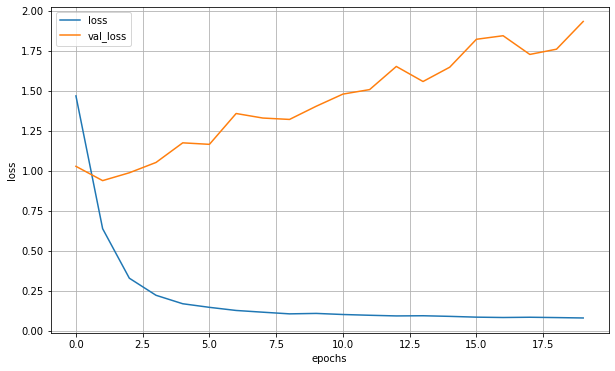

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

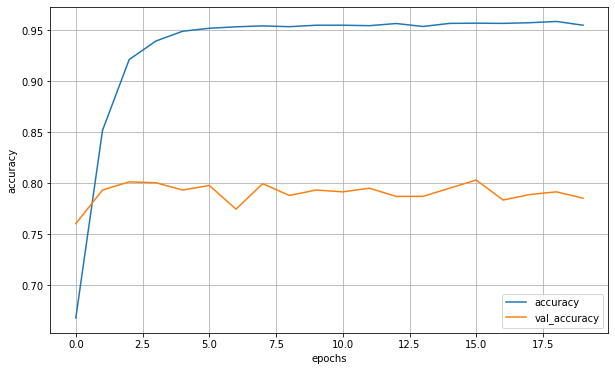

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [33]:
model.evaluate(X_test, Y_test)

36/36 [==============================] - 0s 1ms/step - loss: 1.9920 - accuracy: 0.7649


[1.9919935464859009, 0.764915406703949]

In [37]:
model.predict(X_test).round(0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# TP5 - En la siguiente celda de texto comente los resultados obtenidos del experimento

Una vez realizado el tuning, se obtuvieron los siguientes valores:
* Units: 80
* Layers: 3
* Learning rate: 0.001

En los gráficos, podemos notar que el accuracy sube y el loss baja en los primeros epochs. Entre el epoch 5 u el 7, los cambios para loss son mínimos. Este mismo comportamiento se observa en el accuracy para el accuracy entre los epochs 4 y 5. Además, el loss llega a estar debajo de 0.09 y el accuracy por arriba de 0.95.

Esto pareciera indicarnos que el modelo está aprendiendo bien, que puede dejarse de entrenar a partir del epoch 5 más o menos y que está realizando buenas predicciones.

No obstante, cuando evaluamos el modelo, obtenemos un loss de 1.9920 y un accuracy de 0.7649, lo cuál no es tan deseable. Adicionalmente, notamos en los gráficos que el val_loss incrementa constantemente y que el val_loss se mantiene constante. Esto pareciera indicar que nuesto modelo está sobreajustado.